# News Pipeline Data Visualization

This notebook explores and visualizes the AI & Marketing news data stored in DuckDB.

## Overview
- **Database**: `data/news.duckdb`
- **Schemas**: `raw`, `processed`, `final`
- **Purpose**: Analyze article trends, sources, and data quality

In [2]:
# Import required libraries
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime, timedelta

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## 1. Database Connection

Connect to the DuckDB database and explore available tables.

In [ ]:
# Connect to DuckDB database
db_path = Path("../data/news.duckdb")

if not db_path.exists():
    print(f"❌ Database not found at {db_path}")
    print("Run the Dagster pipeline first to create data.")
else:
    conn = duckdb.connect(str(db_path))
    print(f"✅ Connected to database: {db_path}")
    
    # List all tables
    tables = conn.execute("""
        SELECT table_schema, table_name 
        FROM information_schema.tables 
        WHERE table_schema IN ('raw', 'processed', 'final')
        ORDER BY table_schema, table_name
    """).fetchdf()
    
    print("\n📊 Available tables:")
    print(tables.to_string(index=False))

✅ Connected to database: ..\data\news.duckdb

📊 Available tables:
table_schema            table_name
         raw ai_marketing_news_raw
         raw         filtered_news
         raw        processed_news


## 2. Data Overview

Get a quick overview of the data in each stage of the pipeline.

In [5]:
# Load data from each stage
raw_df = conn.execute("SELECT * FROM raw.ai_marketing_news_raw").fetchdf()
processed_df = conn.execute("SELECT * FROM raw.processed_news").fetchdf()
final_df = conn.execute("SELECT * FROM raw.filtered_news").fetchdf()

# Display summary statistics
print("📈 Pipeline Stage Summary")
print("=" * 60)
print(f"Raw Articles:       {len(raw_df):,} rows")
print(f"Processed Articles: {len(processed_df):,} rows (after deduplication)")
print(f"Final Articles:     {len(final_df):,} rows (after filtering)")
print(f"\nDuplicates Removed: {len(raw_df) - len(processed_df):,}")
print(f"Invalid Removed:    {len(processed_df) - len(final_df):,}")
print(f"Overall Retention:  {len(final_df)/len(raw_df)*100:.1f}%" if len(raw_df) > 0 else "N/A")

📈 Pipeline Stage Summary
Raw Articles:       100 rows
Processed Articles: 100 rows (after deduplication)
Final Articles:     100 rows (after filtering)

Duplicates Removed: 0
Invalid Removed:    0
Overall Retention:  100.0%


In [6]:
# Display sample data from final stage
print("\n📰 Sample Articles (Final Stage):")
print("=" * 60)
final_df[['title', 'source_name', 'publishedAt']].head(5)


📰 Sample Articles (Final Stage):


,title,source_name,publishedAt
0,How European firms are embracing AI and change,"The Lawyer | Legal insight, benchmarking data ...",2025-12-16 12:17:03+01:00
1,Smartstream relocates North American HQ to Man...,Finextra Research,2025-12-16 10:58:35+01:00
2,Propagate India elevates Parikshit Bhattachary...,Economic Times,2025-12-16 09:08:00+01:00
3,Rebellions Challenges NVIDIA in AI Inference M...,Chosun.com,2025-12-16 09:05:37+01:00
4,When Brands Grow a Personality: Inside the Ris...,Medium,2025-12-16 08:24:49+01:00


## 3. Time Series Analysis

Visualize article publication trends over time.

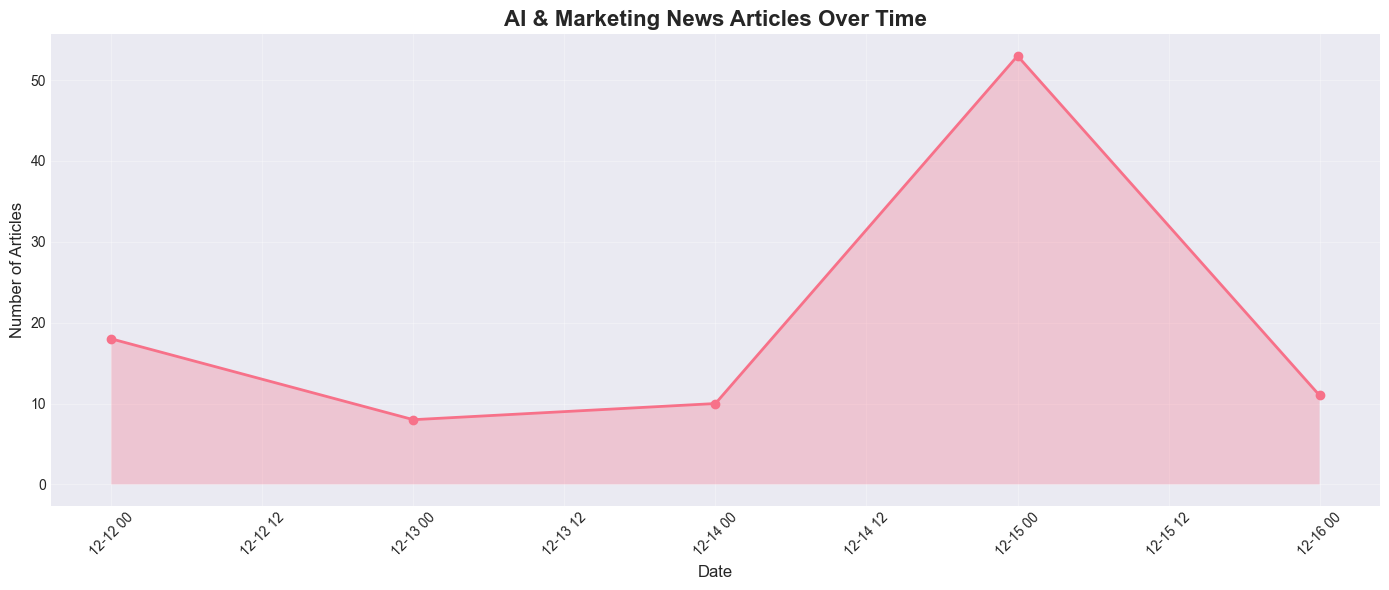

📅 Date Range: 2025-12-12 to 2025-12-16
📊 Average articles per day: 20.0


In [7]:
# Prepare time series data
final_df['publishedAt'] = pd.to_datetime(final_df['publishedAt'])
final_df['date'] = final_df['publishedAt'].dt.date

# Count articles per day
daily_counts = final_df.groupby('date').size().reset_index(name='count')
daily_counts['date'] = pd.to_datetime(daily_counts['date'])

# Create time series plot
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(daily_counts['date'], daily_counts['count'], marker='o', linewidth=2, markersize=6)
ax.fill_between(daily_counts['date'], daily_counts['count'], alpha=0.3)

ax.set_title('AI & Marketing News Articles Over Time', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Number of Articles', fontsize=12)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"📅 Date Range: {daily_counts['date'].min().date()} to {daily_counts['date'].max().date()}")
print(f"📊 Average articles per day: {daily_counts['count'].mean():.1f}")

## 4. Top News Sources

Analyze which sources publish the most AI & Marketing content.

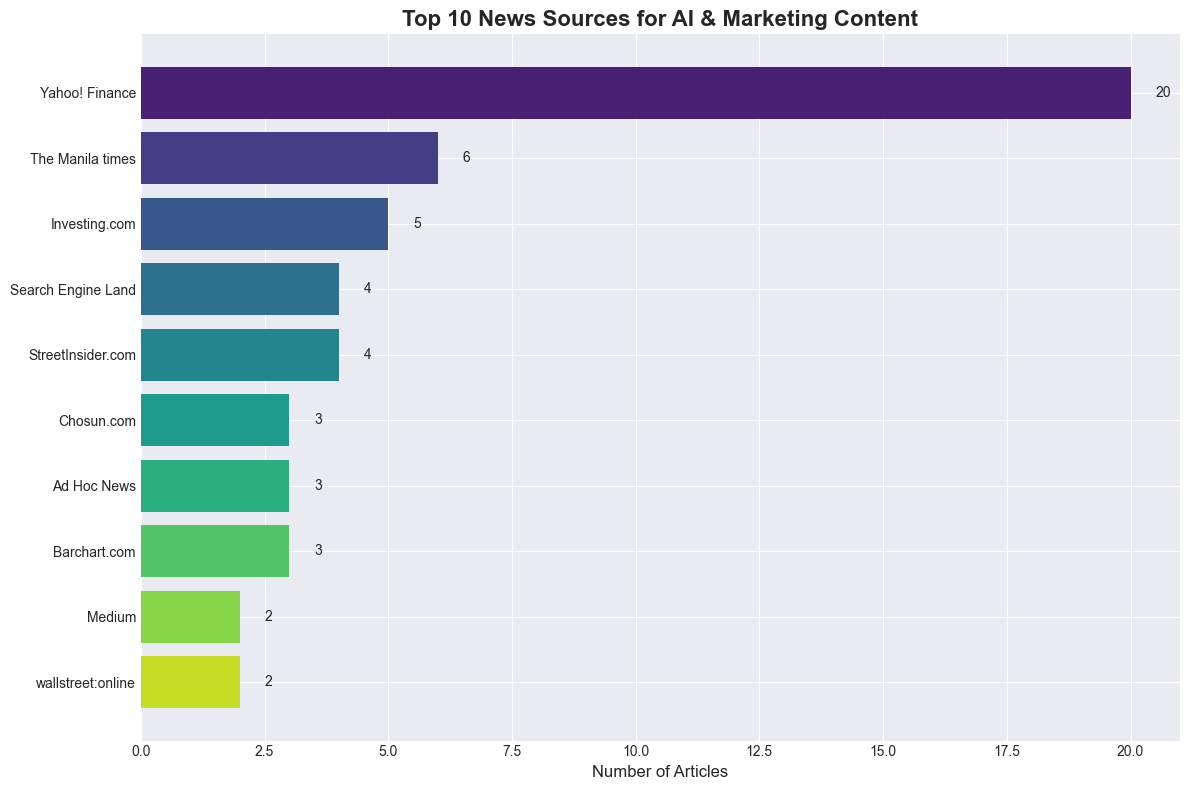


🏆 Top Source: Yahoo! Finance (20 articles)


In [8]:
# Count articles by source
source_counts = final_df['source_name'].value_counts().head(10)

# Create horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 8))
colors = sns.color_palette("viridis", len(source_counts))
bars = ax.barh(range(len(source_counts)), source_counts.values, color=colors)

ax.set_yticks(range(len(source_counts)))
ax.set_yticklabels(source_counts.index)
ax.set_xlabel('Number of Articles', fontsize=12)
ax.set_title('Top 10 News Sources for AI & Marketing Content', fontsize=16, fontweight='bold')
ax.invert_yaxis()

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, source_counts.values)):
    ax.text(value + 0.5, i, str(value), va='center', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\n🏆 Top Source: {source_counts.index[0]} ({source_counts.values[0]} articles)")

## 5. Publication Time Analysis

Analyze when articles are typically published (hour of day).

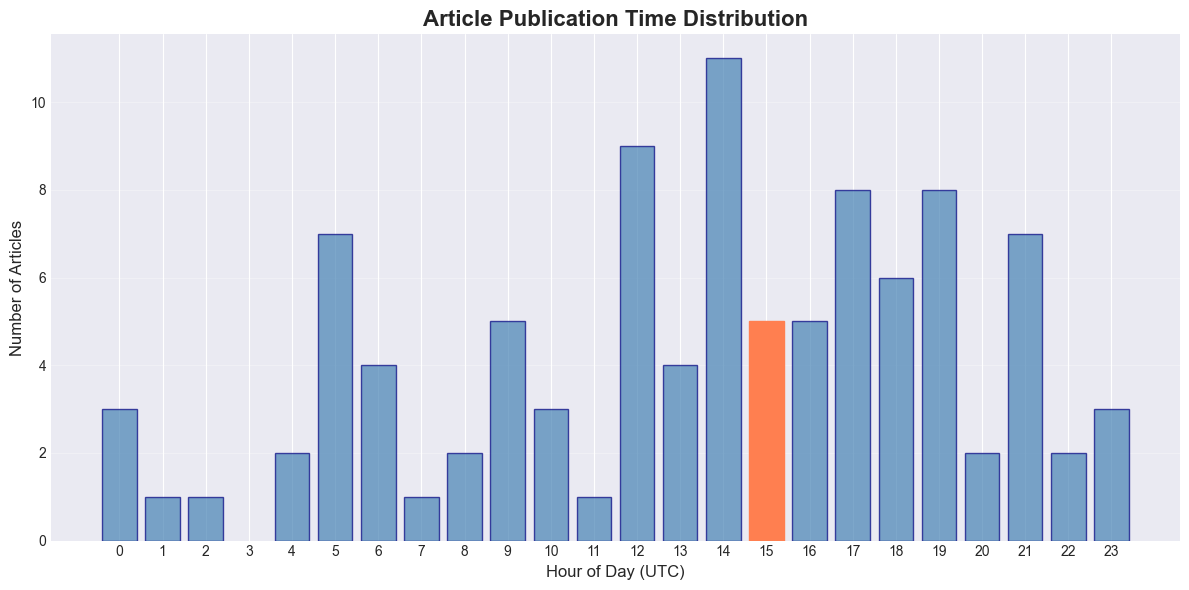

⏰ Peak publication hour: 14:00 UTC (11 articles)
📊 Most articles published between [14, 12, 17] UTC


In [9]:
# Extract hour from timestamp
final_df['hour'] = final_df['publishedAt'].dt.hour
hourly_counts = final_df['hour'].value_counts().sort_index()

# Create circular/radial bar chart effect
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(hourly_counts.index, hourly_counts.values, color='steelblue', alpha=0.7, edgecolor='navy')

# Highlight peak hours
peak_hour = hourly_counts.idxmax()
bars[peak_hour].set_color('coral')
bars[peak_hour].set_alpha(1.0)

ax.set_xlabel('Hour of Day (UTC)', fontsize=12)
ax.set_ylabel('Number of Articles', fontsize=12)
ax.set_title('Article Publication Time Distribution', fontsize=16, fontweight='bold')
ax.set_xticks(range(0, 24))
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"⏰ Peak publication hour: {peak_hour}:00 UTC ({hourly_counts.max()} articles)")
print(f"📊 Most articles published between {hourly_counts.nlargest(3).index.tolist()} UTC")

## 6. Data Quality Metrics

Visualize the pipeline's data quality and filtering effectiveness.

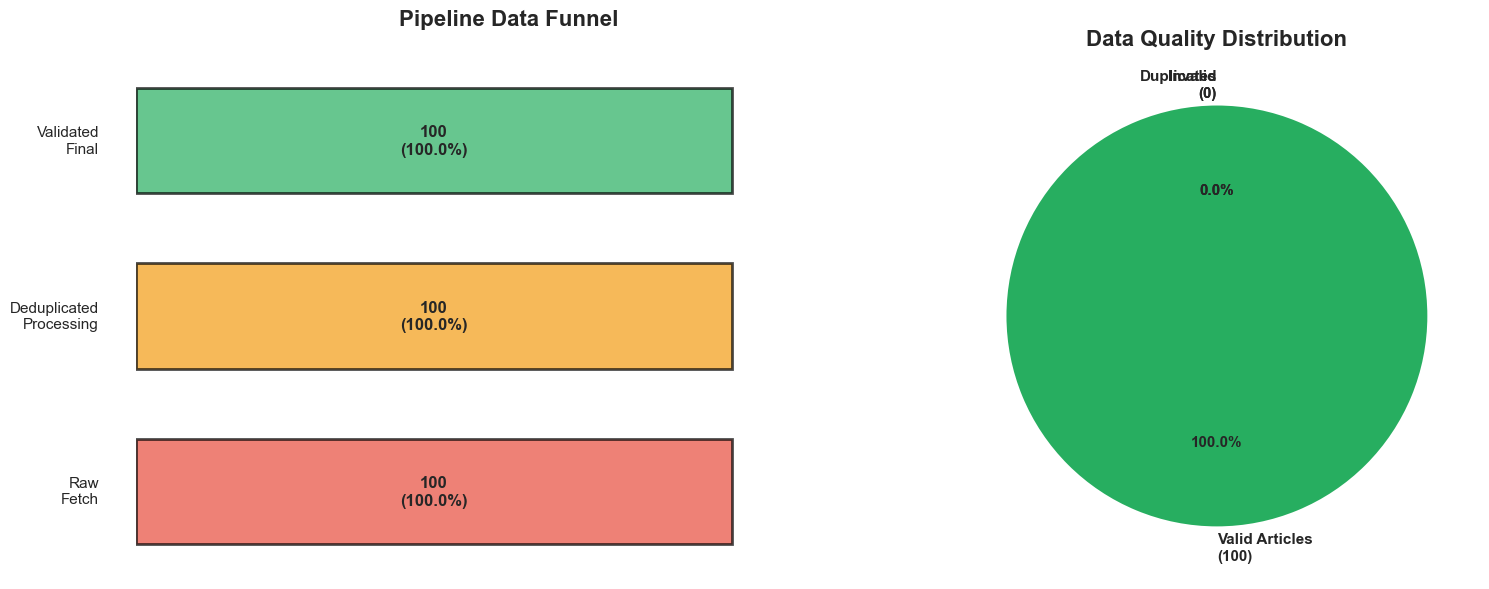

✅ Data Quality Score: 100.0% retention rate


In [10]:
# Pipeline funnel data
stages = ['Raw\nFetch', 'Deduplicated\nProcessing', 'Validated\nFinal']
counts = [len(raw_df), len(processed_df), len(final_df)]
colors_funnel = ['#e74c3c', '#f39c12', '#27ae60']

# Create funnel chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Funnel visualization
for i, (stage, count, color) in enumerate(zip(stages, counts, colors_funnel)):
    width = count / max(counts) * 0.8
    ax1.barh(i, width, height=0.6, color=color, alpha=0.7, edgecolor='black', linewidth=2)
    ax1.text(width/2, i, f'{count:,}\n({count/max(counts)*100:.1f}%)', 
             ha='center', va='center', fontsize=12, fontweight='bold')
    ax1.text(-0.05, i, stage, ha='right', va='center', fontsize=11)

ax1.set_xlim(0, 1)
ax1.set_ylim(-0.5, len(stages)-0.5)
ax1.axis('off')
ax1.set_title('Pipeline Data Funnel', fontsize=16, fontweight='bold', pad=20)

# Data quality pie chart
removed_duplicates = len(raw_df) - len(processed_df)
removed_invalid = len(processed_df) - len(final_df)
kept = len(final_df)

quality_data = [kept, removed_duplicates, removed_invalid]
quality_labels = [f'Valid Articles\n({kept:,})', 
                  f'Duplicates\n({removed_duplicates:,})', 
                  f'Invalid\n({removed_invalid:,})']
quality_colors = ['#27ae60', '#e67e22', '#e74c3c']

ax2.pie(quality_data, labels=quality_labels, colors=quality_colors, autopct='%1.1f%%',
        startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
ax2.set_title('Data Quality Distribution', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"✅ Data Quality Score: {len(final_df)/len(raw_df)*100:.1f}% retention rate")

## 7. Article Length Analysis

Analyze the distribution of article content lengths.

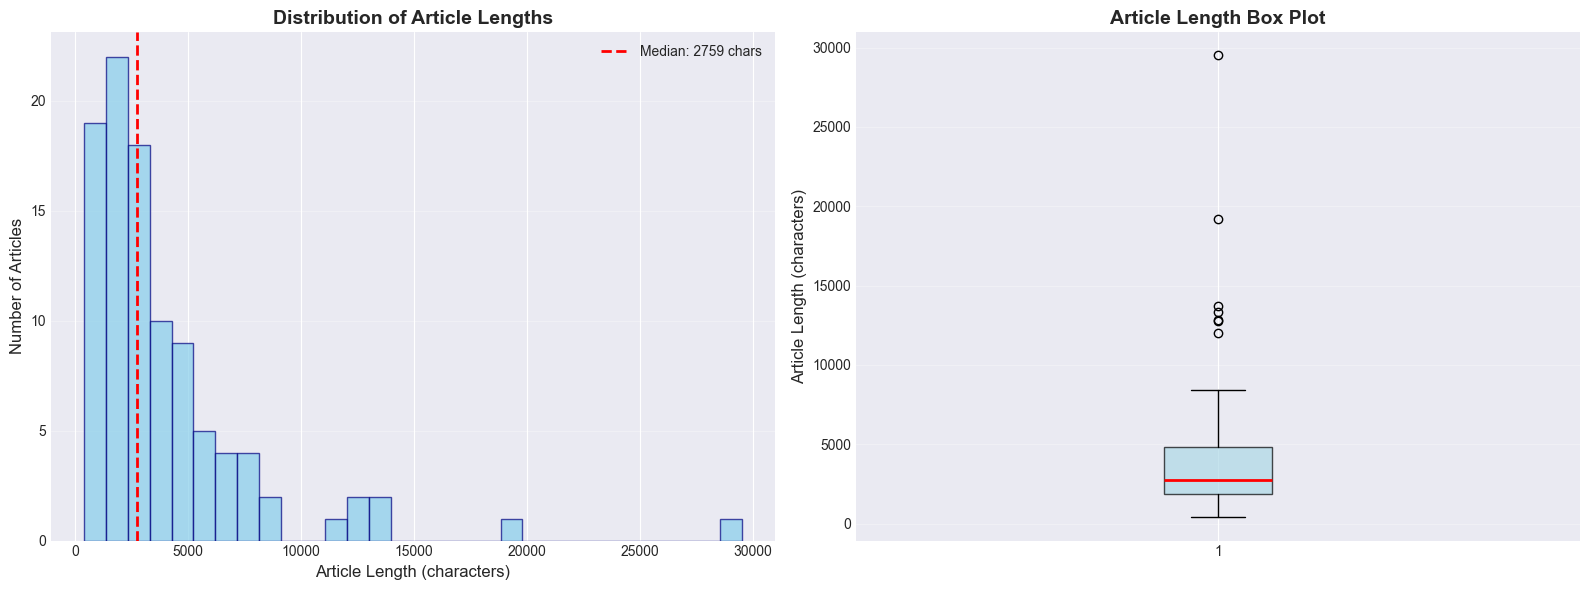

📊 Article Length Statistics:
   Mean:   4043 characters
   Median: 2759 characters
   Min:    393 characters
   Max:    29510 characters


In [11]:
# Calculate article lengths (if body column exists)
if 'body' in final_df.columns:
    final_df['content_length'] = final_df['body'].str.len()
    
    # Create histogram
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Histogram
    ax1.hist(final_df['content_length'], bins=30, color='skyblue', edgecolor='navy', alpha=0.7)
    ax1.axvline(final_df['content_length'].median(), color='red', linestyle='--', 
                linewidth=2, label=f'Median: {final_df["content_length"].median():.0f} chars')
    ax1.set_xlabel('Article Length (characters)', fontsize=12)
    ax1.set_ylabel('Number of Articles', fontsize=12)
    ax1.set_title('Distribution of Article Lengths', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # Box plot
    ax2.boxplot(final_df['content_length'], vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                medianprops=dict(color='red', linewidth=2))
    ax2.set_ylabel('Article Length (characters)', fontsize=12)
    ax2.set_title('Article Length Box Plot', fontsize=14, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"📊 Article Length Statistics:")
    print(f"   Mean:   {final_df['content_length'].mean():.0f} characters")
    print(f"   Median: {final_df['content_length'].median():.0f} characters")
    print(f"   Min:    {final_df['content_length'].min():.0f} characters")
    print(f"   Max:    {final_df['content_length'].max():.0f} characters")
else:
    print("⚠️ Body column not found in dataset")

## 8. Recent Articles

Display the most recent articles from the database.

In [12]:
# Get the 10 most recent articles
recent_articles = final_df.nlargest(10, 'publishedAt')[['title', 'source_name', 'publishedAt', 'url']]

print("📰 10 Most Recent AI & Marketing Articles:")
print("=" * 80)
for idx, row in recent_articles.iterrows():
    print(f"\n{row['publishedAt'].strftime('%Y-%m-%d %H:%M')} | {row['source_name']}")
    print(f"📌 {row['title']}")
    print(f"🔗 {row['url']}")

📰 10 Most Recent AI & Marketing Articles:

2025-12-16 12:17 | The Lawyer | Legal insight, benchmarking data and jobs
📌 How European firms are embracing AI and change
🔗 https://www.thelawyer.com/how-european-firms-are-embracing-ai-and-change/

2025-12-16 10:58 | Finextra Research
📌 Smartstream relocates North American HQ to Manhattan
🔗 https://www.finextra.com/pressarticle/108334/smartstream-relocates-north-american-hq-to-manhattan

2025-12-16 09:08 | Economic Times
📌 Propagate India elevates Parikshit Bhattacharya to Chief Creative Officer
🔗 https://economictimes.indiatimes.com/news/company/corporate-trends/propagate-india-elevates-parikshit-bhattacharya-to-chief-creative-officer/articleshow/125999191.cms

2025-12-16 09:05 | Chosun.com
📌 Rebellions Challenges NVIDIA in AI Inference Market
🔗 https://www.chosun.com/english/industry-en/2025/12/16/CNDZBFHEUVG6RKFYFVDUI5KCPA/

2025-12-16 08:24 | Medium
📌 When Brands Grow a Personality: Inside the Rise of Autonomous AI Characters
🔗 https://r